# Instant Recognition with Caffe

In this example we'll classify an image with the bundled CaffeNet model based on the network architecture of Krizhevsky et al. for ImageNet. We'll compare CPU and GPU operation then reach into the model to inspect features and the output.

(These feature visualizations follow the DeCAF visualizations originally by Yangqing Jia.)

First, import required modules, set plotting parameters, and run `./scripts/download_model_binary.py models/bvlc_reference_caffenet` to get the pretrained CaffeNet model if it hasn't already been fetched.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '/Users/anand/dev/caffe'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os

classes = {
    11: 'Open Water',
    12: 'Perennial Ice/Snow',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed High Intensity',
    31: 'Barren Land (Rock/Sand/Clay)',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    51: 'Dwarf Scrub',
    52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous',
    72: 'Sedge/Herbaceous',
    73: 'Lichens',
    74: 'Moss',
    81: 'Pasture/Hay',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands'
}

In [2]:
caffe.set_device(0)
caffe.set_mode_gpu()

def run_net(weights):
    net = caffe.Net('caffenet/train_val.prototxt', weights, caffe.TEST)
    print([(k, v.data.shape) for k, v in net.blobs.items()])

    # input preprocessing: 'data' is the name of the input blob == net.inputs[0]
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', np.load('temp/learnsat_mean.npy').mean(1).mean(1)) # mean pixel
    transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
    transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

    # Feed in the image (with some preprocessing) and classify with a forward pass.
    net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image('images/val/LT50220292011187GNC01.4096.3328.TIF'))
    out = net.forward()
    return out, net, transformer

out, net, transformer = run_net('temp/snap/caffenet_train_iter_32000.caffemodel')
print(out)
print("Predicted class is #{}.".format(out['prob'].argmax()))
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
[ classes[c] for c in top_k ]



[('data', (16, 3, 113, 113)), ('label', (16,)), ('label_data_1_split_0', (16,)), ('label_data_1_split_1', (16,)), ('conv1', (16, 96, 26, 26)), ('pool1', (16, 96, 13, 13)), ('norm1', (16, 96, 13, 13)), ('conv2', (16, 256, 13, 13)), ('pool2', (16, 256, 6, 6)), ('norm2', (16, 256, 6, 6)), ('conv3', (16, 384, 6, 6)), ('conv4', (16, 384, 6, 6)), ('conv5', (16, 256, 6, 6)), ('pool5', (16, 256, 3, 3)), ('fc6', (16, 4096)), ('fc7', (16, 4096)), ('fc8', (16, 1000)), ('fc8_fc8_0_split_0', (16, 1000)), ('fc8_fc8_0_split_1', (16, 1000)), ('fc8_fc8_0_split_2', (16, 1000)), ('accuracy', ()), ('prob', (16, 1000)), ('loss', ())]
{'loss': array(2.1913020610809326, dtype=float32), 'prob': array([[  3.19640162e-06,   8.29276908e-03,   3.19168362e-06, ...,
          3.18946513e-06,   3.19052697e-06,   3.19768833e-06],
       [  3.19640162e-06,   8.29276908e-03,   3.19168362e-06, ...,
          3.18946513e-06,   3.19052697e-06,   3.19768833e-06],
       [  3.19640162e-06,   8.29276908e-03,   3.19168362e-06

['Deciduous Forest',
 'Developed, Open Space',
 'Cultivated Crops',
 'Open Water',
 'Woody Wetlands']

What did the input look like?

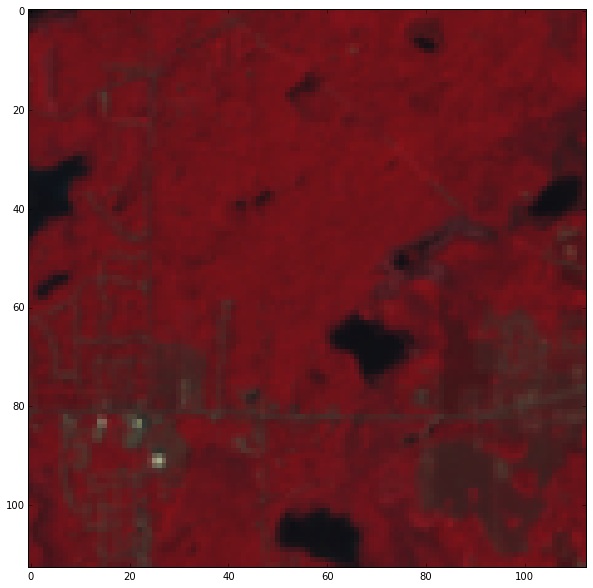

In [58]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

In [13]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (50, 3, 113, 113)),
 ('conv1', (50, 96, 26, 26)),
 ('pool1', (50, 96, 13, 13)),
 ('norm1', (50, 96, 13, 13)),
 ('conv2', (50, 256, 13, 13)),
 ('pool2', (50, 256, 6, 6)),
 ('norm2', (50, 256, 6, 6)),
 ('conv3', (50, 384, 6, 6)),
 ('conv4', (50, 384, 6, 6)),
 ('conv5', (50, 256, 6, 6)),
 ('pool5', (50, 256, 3, 3)),
 ('fc6', (50, 4096)),
 ('fc7', (50, 4096)),
 ('fc8', (50, 1000)),
 ('prob', (50, 1000))]

The parameters and their shapes. The parameters are `net.params['name'][0]` while biases are `net.params['name'][1]`.

In [14]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (96, 3, 11, 11)),
 ('conv2', (256, 48, 5, 5)),
 ('conv3', (384, 256, 3, 3)),
 ('conv4', (384, 192, 3, 3)),
 ('conv5', (256, 192, 3, 3)),
 ('fc6', (4096, 2304)),
 ('fc7', (4096, 4096)),
 ('fc8', (1000, 4096))]

Helper functions for visualization

In [60]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.imshow(data)

The input image

The first layer filters, `conv1`

conv1 filters
(96, 3, 11, 11)
conv1 outputs
(50, 96, 26, 26)


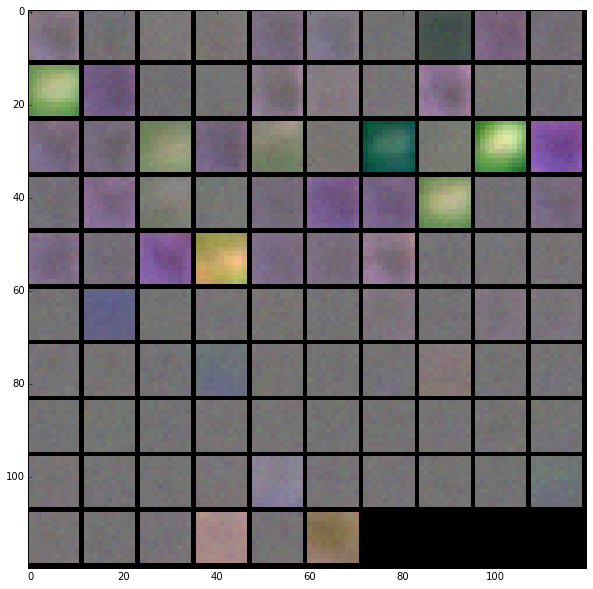

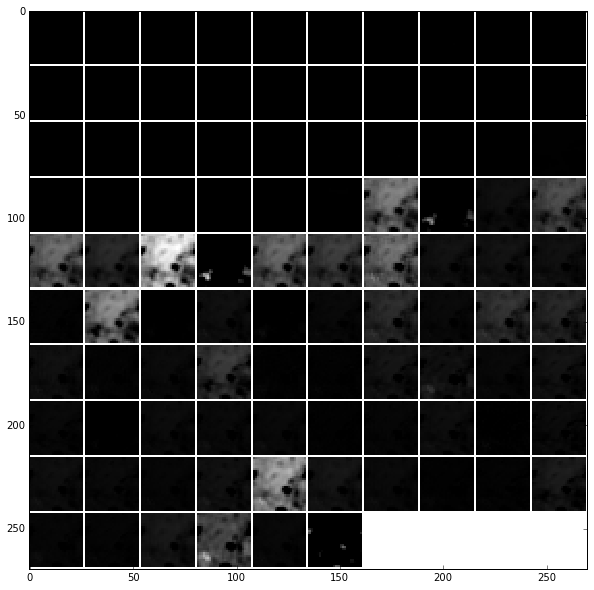

In [53]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data

print('conv1 filters')
print(filters.shape)
print('conv1 outputs')
print(net.blobs['conv1'].data.shape)

vis_square(filters.transpose(0, 2, 3, 1))
feat = net.blobs['conv1'].data[0]
vis_square(feat, padval=1)

The second layer filters, `conv2`

There are 256 filters, each of which has dimension 5 x 5 x 48. We show only the first 48 filters, with each channel shown separately, so that each filter is a row.

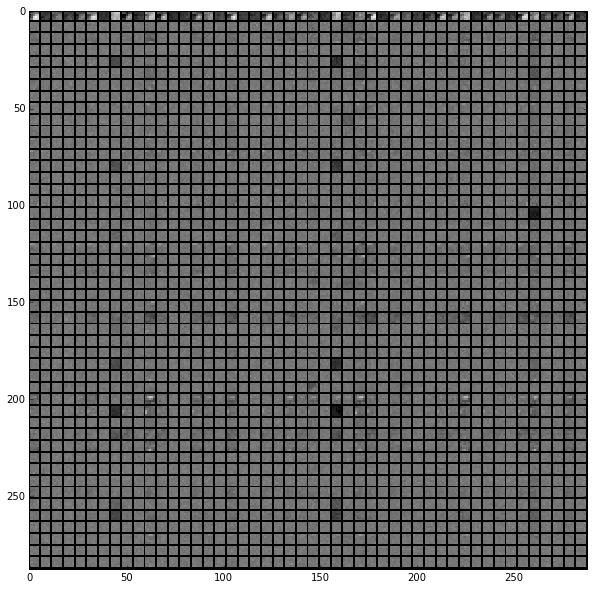

In [54]:
filters = net.params['conv2'][0].data
vis_square(filters[:48].reshape(48**2, 5, 5))
#vis_square(filters)

# The second layer output, `conv2` (rectified, only the first 36 of 256 channels)
feat = net.blobs['conv2'].data[0, :36]
vis_square(feat, padval=1)

The third layer output, `conv3` (rectified, all 384 channels)

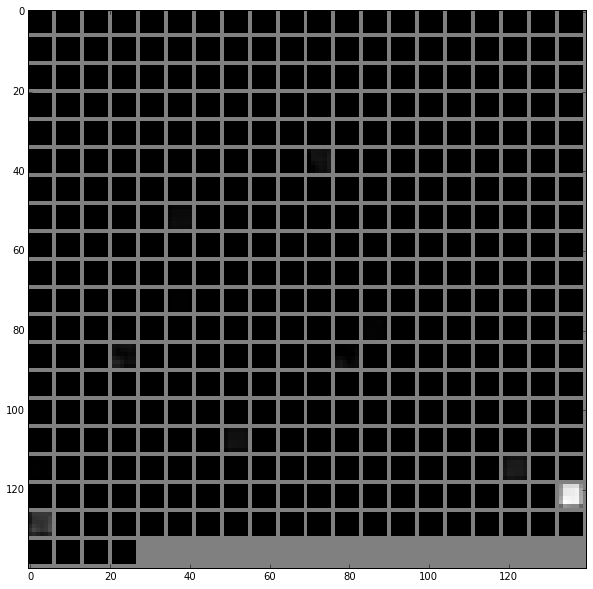

In [20]:
feat = net.blobs['conv3'].data[0]
vis_square(feat, padval=0.5)
# The fourth layer output, `conv4` (rectified, all 384 channels)
feat = net.blobs['conv4'].data[0]
vis_square(feat, padval=0.5)

The fifth layer output, `conv5` (rectified, all 256 channels)

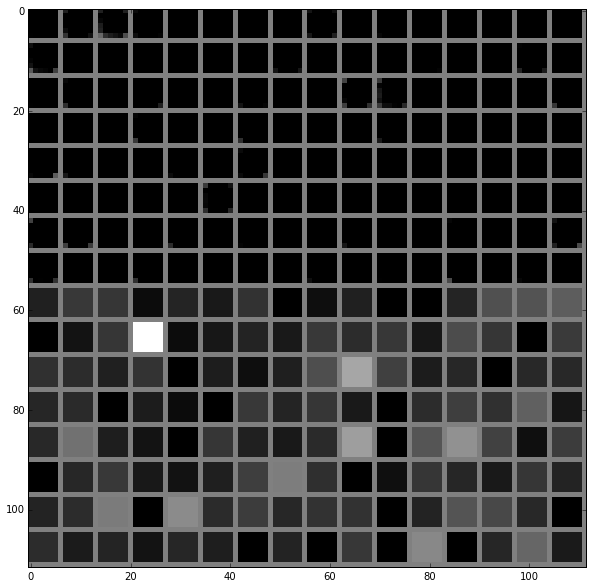

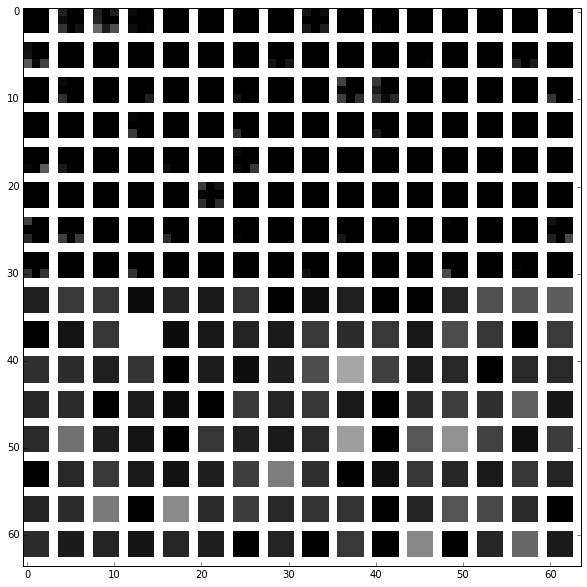

In [55]:
feat = net.blobs['conv5'].data[0]
vis_square(feat, padval=0.5)
# The fifth layer after pooling, `pool5`
feat = net.blobs['pool5'].data[0]
vis_square(feat, padval=1)

The first fully connected layer, `fc6` (rectified)

We show the output values and the histogram of the positive values

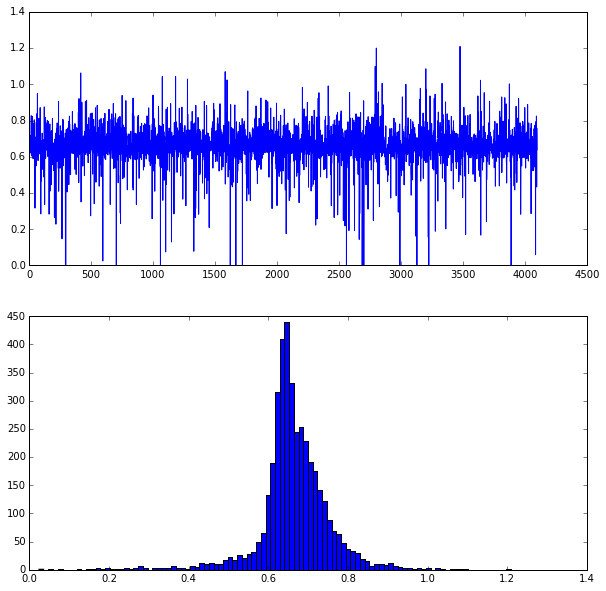

In [47]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

The second fully connected layer, `fc7` (rectified)

ValueError: x must have at least one data point

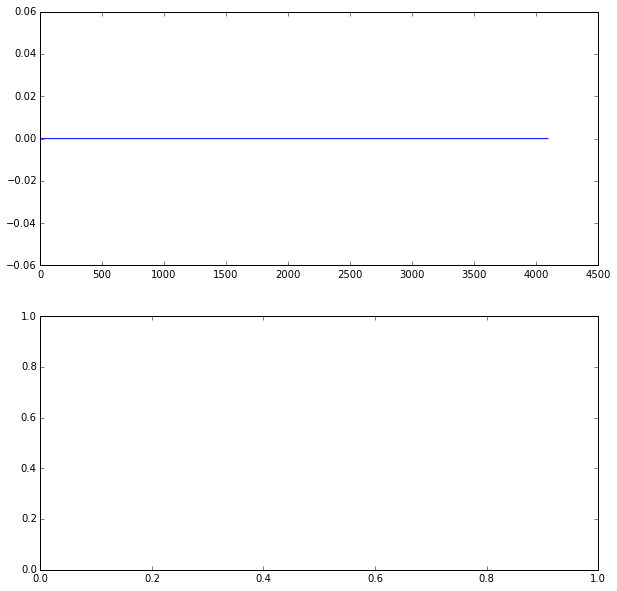

In [27]:
feat = net.blobs['fc7'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

The final probability output, `prob`

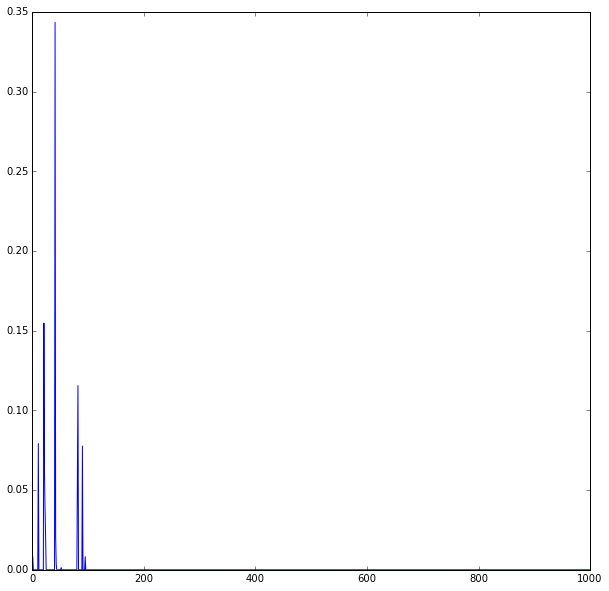

In [28]:
feat = net.blobs['prob'].data[0]
plt.plot(feat.flat)